In [19]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
# %config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM6', 9600, timeout=1)
dut.connect(ser)

dut.reset_chip()
dut.reset_dpe()
dut.ground_PIC()
dut.power_on()

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default


In [40]:
dut.disconnect()

In [4]:
from lib_data import *
import scipy.io as sio
mat_contents = sio.loadmat('UpdatedGfc.mat')
finalGfc = mat_contents['finalGfc']


Array 0 , device (row= 0 col= 0 ) Init G= -7.331378299120228e-08  Target G= 1.9999999949504854e-06  Final G= -7.331378299120228e-08
Array 0 , device (row= 1 col= 0 ) Init G= -7.331378299120228e-08  Target G= 4.981069196219323e-06  Final G= 5.801564027370478e-05
Array 0 , device (row= 2 col= 0 ) Init G= -7.331378299120228e-08  Target G= 1.9999999949504854e-06  Final G= -7.331378299120228e-08
Array 0 , device (row= 3 col= 0 ) Init G= -7.331378299120228e-08  Target G= 7.723643648205325e-05  Final G= 7.965542521994135e-05
Array 0 , device (row= 4 col= 0 ) Init G= -7.331378299120228e-08  Target G= 1.9999999949504854e-06  Final G= -7.331378299120228e-08
Array 0 , device (row= 5 col= 0 ) Init G= -7.331378299120228e-08  Target G= 1.9999999949504854e-06  Final G= -7.331378299120228e-08
Array 0 , device (row= 6 col= 0 ) Init G= -7.331378299120228e-08  Target G= 1.0252914762531873e-05  Final G= 2.076001955034212e-05
Array 0 , device (row= 7 col= 0 ) Init G= -2.7859237536656864e-07  Target G= 1.99

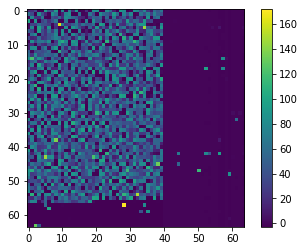

In [5]:
VreadGate = 5.0
vRead = 0.2
arr = 0
startRow = 0
startCol = 0
numRows = 57
numCols = 40
GMin = 2e-6
GMax = 100e-6

# First reshape Gfc to fit within the 64 rows
# reshape from 113x20 to 57x40
newGfc = np.zeros((57,40))+GMin
newGfc[0:57,0:20]=finalGfc[0:57,0:20]
newGfc[0:56,20:40]=finalGfc[57:113,0:20]

targetGVals = newGfc
targetGThresh = 4e-6
targetRows = np.arange(startRow, startRow+numRows)
targetCols = np.arange(startCol, startCol+numCols)

vAppliedSet = np.arange(0.5, 2.5, 0.1)
vAppliedReset = np.arange(0.5, 3.3, 0.1)
vGateSet = np.arange(0.5, 1.7, 0.05)
vGateReset = np.arange(5.0, 5.5, 0.5)

GHistory = []
VHistory = []

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.0, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])

_gain_ratio = [
    1e3,
    5e3,
    30e3,
    200e3,
    1e6
]

vOffset = -0.00
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vgate = 5
Vref = 0.5

for j in range(numCols):
    cc = targetCols[j]
    for i in range(numRows):
        rr = targetRows[i]
        thisGtarget = targetGVals[i,j]
        thisGHistory = []
        thisVHistory = []
        thisGainHistory = []
        # Do a first read of this device
        adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
        VADC_read_first = dut.adc2volt(adc_raw)
        gainFirst = adc_raw >> 10
        secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
        secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
        dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
        VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
        finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
        dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
        rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
        
        currG = rdCurr/vRead
        thisGHistory.append(currG)
        thisVHistory.append(0)
        #print('Initial G=', currG, 'Target G =', thisGtarget)
        initG = currG
        # Now, if device is lower than target, SET it
        if currG < (thisGtarget-targetGThresh):
            for vgate in vGateSet:
                for vappset in vAppliedSet:
                    # Apply vappset pulse, then read
                    a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                    VADC_read_first = dut.adc2volt(adc_raw)
                    gainFirst = adc_raw >> 10
                    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
                
                    currG = rdCurr/vRead
                    thisGHistory.append(currG)
                    thisVHistory.append(vappset)
                    if currG >= (thisGtarget-targetGThresh):
                        break
                if currG >= (thisGtarget-targetGThresh):
                    break
            GHistory.append(thisGHistory)
            VHistory.append(thisVHistory)

        # Else, if device is higher than target, RESET it, then SET it
        elif currG > (thisGtarget+targetGThresh):
            for vgate in vGateReset:
                for vappreset in vAppliedReset:
                    # Apply vappreset pulse, then read
                    a0.reset_single_int(vappreset, vgate, array=arr, row=rr, col=cc)

                    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                    VADC_read_first = dut.adc2volt(adc_raw)
                    gainFirst = adc_raw >> 10
                    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]

                    currG = rdCurr/vRead
                    thisGHistory.append(currG)
                    thisVHistory.append(-1*vappreset)
                    if currG <= (thisGtarget+targetGThresh):
                        break
                if currG <= (thisGtarget+targetGThresh):
                    break

            #Now if it is below Gtarget, then do SET operations; If it is above Gtarget, then Reset failed and device stuck ON
            
            #if currG <= thisGtarget and thisGtarget >= 2.5e-6:
            if currG <= (thisGtarget-targetGThresh):
                for vgate in vGateSet:
                    for vappset in vAppliedSet:
                        # Apply vappset pulse, then read
                        a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                        adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                        VADC_read_first = dut.adc2volt(adc_raw)
                        gainFirst = adc_raw >> 10
                        secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                        secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                        dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                        VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                        finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                        dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                        rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
                    
                        currG = rdCurr/vRead
                        thisGHistory.append(currG)
                        thisVHistory.append(vappset)
                        if currG >= (thisGtarget-targetGThresh):
                            break
                    if currG >= (thisGtarget-targetGThresh):
                        break

        GHistory.append(thisGHistory)
        VHistory.append(thisVHistory)
        print('Array', arr, ', device (row=', rr, 'col=', cc, ') Init G=', initG, ' Target G=', thisGtarget, ' Final G=', currG)

time.sleep(15)
arr = 2
numRows = 64
numCols = 64
vRead = 0.2
vReadGate = 5.0
Gmap2post = np.zeros((numRows, numCols))
for rr in range(numRows):
        for cc in range(numCols):
            adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
            VADC_read_first = dut.adc2volt(adc_raw)
            gainFirst = adc_raw >> 10
            secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
            secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
            dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
            VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
            finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
            dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
            rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
        
            Gmap2post[rr,cc] = 1e6*rdCurr/vRead
plt.imshow(Gmap2post)
plt.colorbar()

time.sleep(15)
save_workspace(vars(), note='Prober1_UpdatedFC_Progr57x40_ARRAY2')

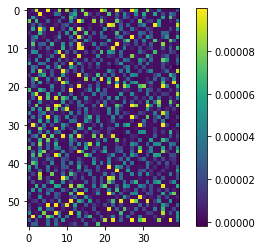

In [7]:
plt.imshow(newGfc)
plt.colorbar()
#plt.imshow(Gmap2post)
#plt.colorbar()

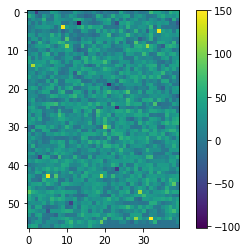

In [10]:
plt.imshow(Gmap2post[0:57,0:40]-1e6*newGfc)
plt.colorbar()
#plt.imshow(Gmap2post)
#plt.colorbar()

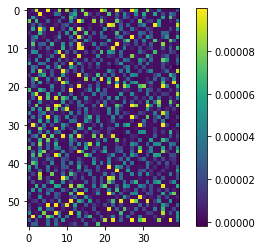

In [14]:
plt.imshow(newGfc)
plt.colorbar()

In [17]:
dut.disconnect()

In [11]:
save_workspace(vars(), note='Prober1_newFC_results')

Saving In(<class 'list'>), Out(<class 'dict'>), mat_contents(<class 'dict'>), finalGfc(<class 'numpy.ndarray'>), VreadGate(<class 'float'>), vRead(<class 'float'>), arr(<class 'int'>), startRow(<class 'int'>), startCol(<class 'int'>), numRows(<class 'int'>), numCols(<class 'int'>), GMin(<class 'float'>), GMax(<class 'float'>), newGfc(<class 'numpy.ndarray'>), targetGVals(<class 'numpy.ndarray'>), targetGThresh(<class 'float'>), targetRows(<class 'numpy.ndarray'>), targetCols(<class 'numpy.ndarray'>), vAppliedSet(<class 'numpy.ndarray'>), vAppliedReset(<class 'numpy.ndarray'>), vGateSet(<class 'numpy.ndarray'>), vGateReset(<class 'numpy.ndarray'>), GHistory(<class 'list'>), VHistory(<class 'list'>), VADC_boundary(<class 'numpy.ndarray'>), VRefHiCmp(<class 'numpy.ndarray'>), vOffset(<class 'float'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), Vgate(<class 'int'>), Vref(<class 'float'>), j(<class 'int'>), cc(<class 'int'>), i(<clas

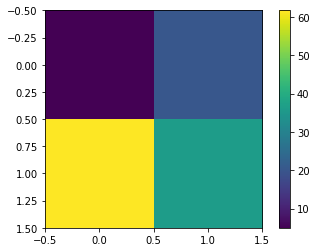

In [20]:
VreadGate = 5.0
vRead = 0.2

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.0, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])

_gain_ratio = [
    1e3,
    5e3,
    30e3,
    200e3,
    1e6
]

vOffset = -0.00
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vgate = 5
Vref = 0.5

arr = 2
numRows = 2
numCols = 2
vRead = 0.2
vReadGate = 5.0
Gmap = np.zeros((numRows, numCols))
for rr in range(numRows):
        for cc in range(numCols):
            adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
            VADC_read_first = dut.adc2volt(adc_raw)
            gainFirst = adc_raw >> 10
            secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
            secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
            dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
            VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
            finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
            dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
            rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
        
            Gmap[rr,cc] = 1e6*rdCurr/vRead
plt.imshow(Gmap)
plt.colorbar()

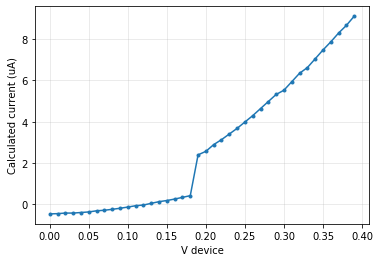

In [23]:
VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.3, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])

_gain_ratio = [
    1e3,
    5e3,
    30e3,
    200e3,
    1e6
]

vOffset = 0.00
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vgate = 5
Vref = 0.5

arr = 2
rr = 0
cc = 0
vRead = 0.2
vreads = np.arange(0,0.4,0.01)

currs = []
for vRead in vreads:
        
    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw)
    gainFirst = adc_raw >> 10
    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
    currs.append(rdCurr)
        
plt.plot(vreads, [i* 1e6 for i in currs], '.-')
    
plt.xlabel('V device')
plt.ylabel('Calculated current (uA)')
plt.grid(True, alpha=0.3)

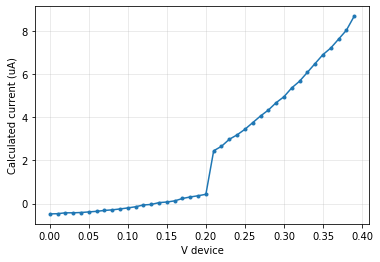

In [38]:
VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.3, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])

_gain_ratio = [
    1e3,
    5e3,
    30e3,
    200e3,
    1e6
]

vOffset = 0.00
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vgate = 5
Vref = 0.5

arr = 2
rr = 0
cc = 0
vRead = 0.2
vreads = np.arange(0,0.4,0.01)

currs = []
for vRead in vreads:
        
    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw) 
    gainFirst = adc_raw >> 10
    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
    currs.append(rdCurr)
        
plt.plot(vreads, [i* 1e6 for i in currs], '.-')
    
plt.xlabel('V device')
plt.ylabel('Calculated current (uA)')
plt.grid(True, alpha=0.3)

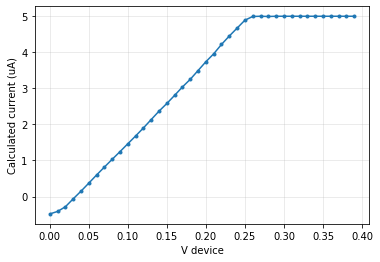

In [30]:
VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.3, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])

_gain_ratio = [
    1e3,
    5e3,
    30e3,
    200e3,
    1e6
]

vOffset = 0.00
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vgate = 5
Vref = 0.5

arr = 2
rr = 1
cc = 0
vRead = 0.2
vreads = np.arange(0,0.4,0.01)

currs = []
for vRead in vreads:
        
    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=4, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw)
    gainFirst = adc_raw >> 10
    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
    currs.append(rdCurr)
        
plt.plot(vreads, [i* 1e6 for i in currs], '.-')
    
plt.xlabel('V device')
plt.ylabel('Calculated current (uA)')
plt.grid(True, alpha=0.3)

In [39]:
dut.disconnect()

In [35]:
dut.vrefs_defaults()

Setting vrefs to default
DAC initialized to a span from -10 V to 10 V
